
#   Tensor Flow implementation of “Artistic Style Transfer” 


In [1]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
COLOR_CHANNELS = 3

## Input Images:

Here we input the content and the style images. The images is then saved as an numpy array of dimension (1,IMG_WIDTH,IMG_HEIGHT,COLOR_CHANNELS) . 

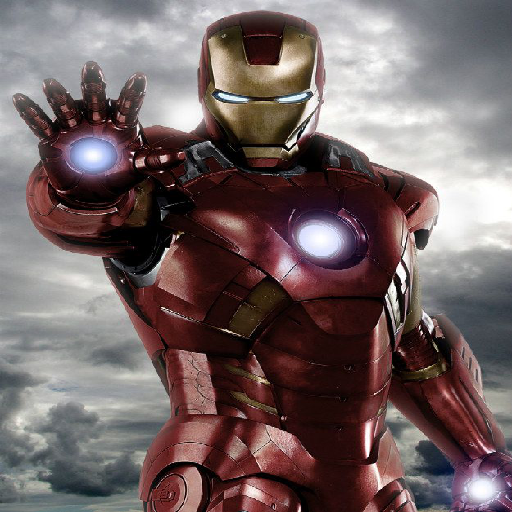

In [3]:
CONTENT_IMG_PATH = 'content1.jpg'
#content_image = scipy.misc.imread(CONTENT_IMG_PATH)
#content_image = np.reshape(content_image, ((1,IMG_HEIGHT,IMG_WIDTH,COLOR_CHANNELS)))
#imshow(content_image[0])

content_image = Image.open(CONTENT_IMG_PATH)
content_image = content_image.resize((IMG_HEIGHT, IMG_WIDTH))
content_image

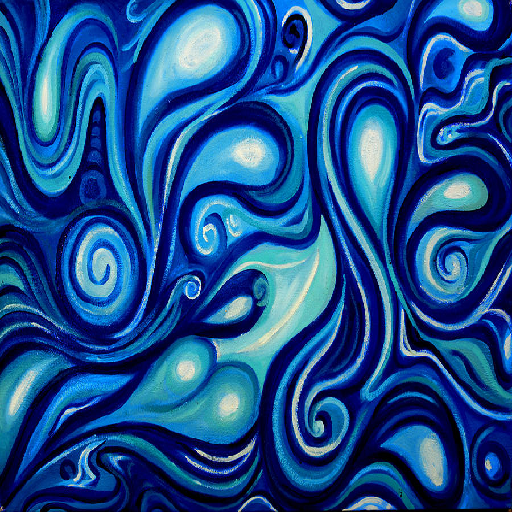

In [4]:
STYLE_IMG_PATH = 'style4.jpg'
#style_image = scipy.misc.imread(STYLE_IMG_PATH)
#style_image = np.reshape(style_image, ((1,IMG_HEIGHT,IMG_WIDTH,COLOR_CHANNELS))
#imshow(style_image[0])

style_image = Image.open(STYLE_IMG_PATH)
style_image = style_image.resize((IMG_HEIGHT, IMG_WIDTH))
style_image

In [5]:
content_image = np.asarray(content_image, dtype='float')
content_image = np.expand_dims(content_image, axis=0)
print(content_image.shape)

style_image = np.asarray(style_image, dtype='float')
style_image = np.expand_dims(style_image, axis=0)
print(style_image.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)




## Loss Functions:

Here we calculate the Content Loss, Style Loss and Total Loss.

In [6]:
def content_loss(Ac, Ag):
    N = Ac.shape[3]
    M = Ac.shape[1] * Ac.shape[2]
    return tf.reduce_sum(tf.square(Ac - Ag)) / (4.0 * M * N)

In [7]:
def gram_matrix(x):
    return tf.matmul(tf.transpose(x), x)

In [8]:
def style_cost_layer(As, Ag):
    N = As.shape[3]
    M = As.shape[1] * As.shape[2]
    As = tf.reshape(As, (M,N))
    Ag = tf.reshape(Ag, (M,N))
    S = gram_matrix(As)
    G = gram_matrix(Ag)
    return tf.reduce_sum(tf.square(S - G)) / ((2.0 * M * N)** 2)

The STYLE_LAYERS variable denotes the weightage of each activation layer to the generated image. 

In [9]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2) ]

In [10]:
def style_loss(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, weight in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = style_cost_layer(a_S, a_G)
        J_style += weight * J_style_layer

    return J_style

In [11]:
def total_loss(J_content, J_style, alpha, beta):
    return alpha * J_content + beta * J_style

## Load the Model:

Here we load the VGG19 Model and construct a graph.
The MaxPool layers in the VGG Model is replaced by AvgPool layers as specifiedin the paper.

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [13]:
def load_vgg_model(path):
     
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        W = vgg_layers[0][layer][0][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [14]:
MODEL_PATH = 'imagenet-vgg-verydeep-19.mat'
#model = scipy.io.loadmat(MODEL_PATH)
#model_layers = model['layers']
#print(model)

model = load_vgg_model(MODEL_PATH)
print(model)

{'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 512, 512, 64) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 32, 32, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 256, 256, 64) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 32, 32, 512) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 128, 128, 128) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 64, 64, 512) dtype=float32>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 32, 32, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 32, 32, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 32, 32, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 64, 64, 512) dtype=float32>, 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 16, 16, 512) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0'

## Generated Image:

Here the generated image is initialized as a noise image having some attributes of the content image. We would then add style to this generated image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


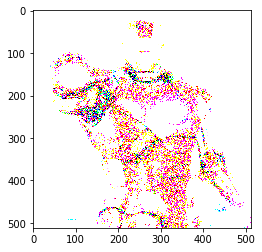

In [15]:
noise_ratio = 0.6
noise_image = np.random.uniform(-20, 20, (1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)).astype('float32')
input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
imshow(input_image[0])

## Tensor Flow Session:

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
#Content Image
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = content_loss(a_C, a_G)

In [18]:
#Style Image
sess.run(model['input'].assign(style_image))
J_style = style_loss(model, STYLE_LAYERS)

In [19]:
alpha = 10
beta = 40

J_total = total_loss(J_content, J_style, alpha, beta)

Here we use Adam Optimizer. Our main motive is to minimize the total loss of the generated image.

In [20]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J_total)

sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(input_image))

array([[[[35.902683 , 48.48071  , 50.36701  ],
         [43.641647 , 37.356667 , 49.413177 ],
         [43.141575 , 43.079956 , 45.297173 ],
         ...,
         [41.940952 , 42.891857 , 46.088364 ],
         [20.206264 , 24.859158 , 24.942232 ],
         [23.005083 , 34.63675  , 40.02094  ]],

        [[49.943172 , 35.671127 , 51.96986  ],
         [52.872    , 34.494408 , 56.10956  ],
         [49.346367 , 49.858185 , 49.27809  ],
         ...,
         [26.236572 , 44.953423 , 28.478336 ],
         [33.93773  , 35.39395  , 41.33635  ],
         [19.258068 , 27.736794 , 27.735634 ]],

        [[30.644861 , 38.808044 , 40.392998 ],
         [31.575508 , 38.200237 , 57.27527  ],
         [33.492012 , 44.36734  , 44.217716 ],
         ...,
         [33.665154 , 34.36625  , 37.70287  ],
         [26.909872 , 29.55641  , 38.33078  ],
         [36.154266 , 24.043938 , 29.37964  ]],

        ...,

        [[50.816555 , 49.679394 , 37.124706 ],
         [41.295795 , 58.598526 , 48.379917 ]

Iteration 0 :
total cost = 104856610000.0
content cost = 16346.947
style cost = 2621411000.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Iteration 20 :
total cost = 29106390000.0
content cost = 39735.97
style cost = 727649800.0
Iteration 40 :
total cost = 11459036000.0
content cost = 49238.46
style cost = 286463580.0
Iteration 60 :
total cost = 5996264000.0
content cost = 50443.2
style cost = 149893980.0
Iteration 80 :
total cost = 3848774400.0
content cost = 51372.406
style cost = 96206510.0
Iteration 100 :
total cost = 2812485600.0
content cost = 51892.44
style cost = 70299170.0
Iteration 120 :
total cost = 2234127000.0
content cost = 52277.477
style cost = 55840108.0
Iteration 140 :
total cost = 1870070500.0
content cost = 52546.363
style cost = 46738628.0
Iteration 160 :
total cost = 1616030700.0
content cost = 52787.34
style cost = 40387572.0
Iteration 180 :
total cost = 1424741500.0
content cost = 53010.883
style cost = 35605290.0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


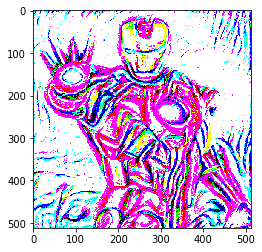

In [21]:
num_iterations = 200

for i in range(num_iterations):
    sess.run(train_step)        
    generated_image = sess.run(model['input'])
    
    # Print every 20 iteration.
    if i%20 == 0:
        Jt, Jc, Js = sess.run([J_total, J_content, J_style])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
            
        # save current generated image in the "/output" directory
        image = generated_image[0]
        #image = np.clip(image, 0, 255).astype('uint8')
        scipy.misc.imsave("output/" + str(i) + ".png", image)
        #save_image("output/" + str(i) + ".png", generated_image)

# save last generated image
image = generated_image[0]
image = np.clip(image, 0, 255).astype('uint8')
scipy.misc.imsave("output/generated_image.jpg", image)
#save_image('output/generated_image.jpg', generated_image)
imshow(generated_image[0])

The Generated Image is saved in the output directory.